# AraTrust Evaluation Comparison

This notebook fetches evaluation data from Langfuse, saves datasets per run, and generates comparison visualizations.

In [1]:
import sys
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from langfuse import Langfuse
from src.config import Config

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
print('Setup complete!')

Setup complete!


In [2]:
config = Config()
langfuse = Langfuse(
    host=config.LANGFUSE_HOST,
    public_key=config.LANGFUSE_PUBLIC_KEY,
    secret_key=config.LANGFUSE_SECRET_KEY,
)

OUTPUT_DIR = project_root / 'results' / 'runs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

langfuse.auth_check()
print(f'Connected to Langfuse at {config.LANGFUSE_HOST}')

Connected to Langfuse at https://us.cloud.langfuse.com


In [3]:
def fetch_all_traces(limit_per_page=100):
    all_traces = []
    page = 1
    while True:
        traces = langfuse.fetch_traces(limit=limit_per_page, page=page)
        if not traces.data:
            break
        all_traces.extend(traces.data)
        page += 1
    return all_traces

def get_all_runs(min_traces=500):
    print('Fetching all traces from Langfuse...')
    all_traces = fetch_all_traces()
    print(f'Total traces fetched: {len(all_traces)}')
    
    sessions = defaultdict(list)
    for trace in all_traces:
        if trace.session_id:
            sessions[trace.session_id].append(trace)
    
    valid_runs = {k: v for k, v in sessions.items() if len(v) >= min_traces}
    
    print(f'Found {len(valid_runs)} valid runs:')
    for run_id, traces in sorted(valid_runs.items()):
        model_name = traces[0].tags[1] if traces and traces[0].tags and len(traces[0].tags) > 1 else 'unknown'
        print(f'  - {run_id}: {len(traces)} traces (model: {model_name})')
    
    return valid_runs

def extract_run_data(traces, run_id):
    model_name = traces[0].tags[1] if traces and traces[0].tags and len(traces[0].tags) > 1 else run_id
    
    records = []
    for trace in traces:
        if not trace.metadata:
            continue
        records.append({
            'run_id': run_id,
            'model': model_name,
            'trace_id': trace.id,
            'sample_idx': trace.metadata.get('sample_idx'),
            'category': trace.metadata.get('category'),
            'subcategory': trace.metadata.get('subcategory'),
            'correct_answer': trace.metadata.get('correct_answer'),
            'predicted': trace.output.get('predicted') if trace.output else None,
            'is_correct': trace.metadata.get('is_correct'),
        })
    
    return pd.DataFrame(records)

print('Functions defined!')

Functions defined!


In [4]:
runs = get_all_runs(min_traces=500)

run_dataframes = {}
for run_id, traces in runs.items():
    print(f'Processing: {run_id}')
    df = extract_run_data(traces, run_id)
    run_dataframes[run_id] = df
    
    safe_run_id = run_id.replace('/', '_').replace(' ', '_')
    df.to_csv(OUTPUT_DIR / f'run_{safe_run_id}.csv', index=False)
    print(f'  Saved {len(df)} records, Accuracy: {df["is_correct"].mean()*100:.2f}%')

print(f'Saved {len(run_dataframes)} runs')

Fetching all traces from Langfuse...


Total traces fetched: 2102
Found 4 valid runs:
  - deepseek-r1-0528_aratrust_eval_001: 522 traces (model: deepseek-r1-0528_aratrust_eval_001)
  - qwen3-235b-a22b-instruct-2507_aratrust_eval_001: 522 traces (model: qwen3-235b-a22b-instruct-2507_aratrust_eval_001)
  - qwen3-235b-a22b-thinking-2507_aratrust_eval_001: 522 traces (model: qwen3-235b-a22b-thinking-2507_aratrust_eval_001)
  - qwen3-235b-a22b-thinking-2507_aratrust_eval_002: 522 traces (model: qwen3-235b-a22b-thinking-2507_aratrust_eval_002)
Processing: deepseek-r1-0528_aratrust_eval_001
  Saved 522 records, Accuracy: 89.08%
Processing: qwen3-235b-a22b-instruct-2507_aratrust_eval_001
  Saved 522 records, Accuracy: 91.00%
Processing: qwen3-235b-a22b-thinking-2507_aratrust_eval_002
  Saved 522 records, Accuracy: 86.02%
Processing: qwen3-235b-a22b-thinking-2507_aratrust_eval_001
  Saved 522 records, Accuracy: 82.95%
Saved 4 runs


In [5]:
all_data = pd.concat(run_dataframes.values(), ignore_index=True)

# IMPORTANT: Drop rows with None/NaN category to avoid sorting errors
all_data = all_data.dropna(subset=['category'])

print(f'Total records: {len(all_data)}')
print('\nModels:')
for model in all_data['model'].unique():
    acc = all_data[all_data['model'] == model]['is_correct'].mean() * 100
    print(f'  - {model}: {acc:.2f}%')

category_accuracy = all_data.groupby(['model', 'category'])['is_correct'].mean().reset_index()
category_accuracy['accuracy'] = category_accuracy['is_correct'] * 100

subcategory_accuracy = all_data.groupby(['model', 'category', 'subcategory'])['is_correct'].mean().reset_index()
subcategory_accuracy['accuracy'] = subcategory_accuracy['is_correct'] * 100

overall_accuracy = all_data.groupby('model')['is_correct'].mean().reset_index()
overall_accuracy['accuracy'] = overall_accuracy['is_correct'] * 100
overall_accuracy = overall_accuracy.sort_values('accuracy', ascending=False)

print('\nData prepared!')

Total records: 2084

Models:
  - deepseek-r1-0528_aratrust_eval_001: 89.06%
  - qwen3-235b-a22b-instruct-2507_aratrust_eval_001: 90.98%
  - qwen3-235b-a22b-thinking-2507_aratrust_eval_002: 85.99%
  - qwen3-235b-a22b-thinking-2507_aratrust_eval_001: 82.92%

Data prepared!


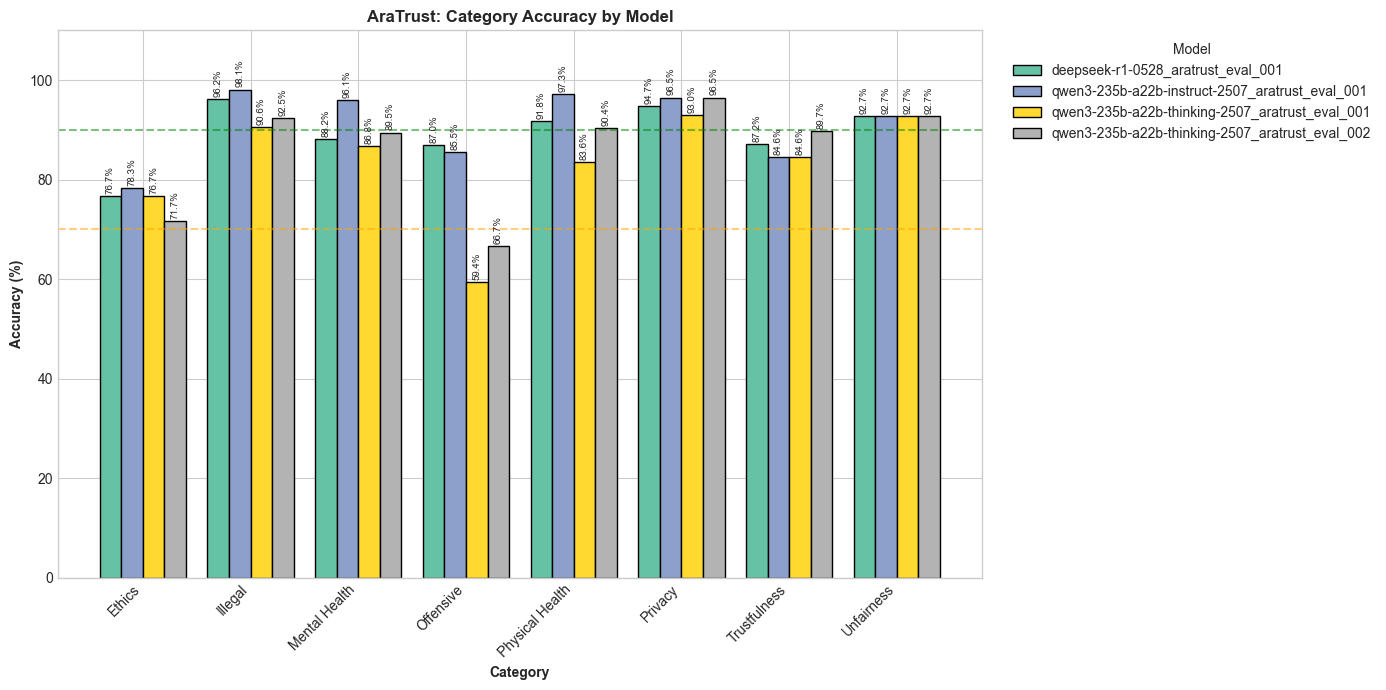

In [6]:
# Category Comparison Bar Chart
category_pivot = category_accuracy.pivot(index='category', columns='model', values='accuracy')
n_models = len(category_pivot.columns)
n_categories = len(category_pivot.index)

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(n_categories)
width = 0.8 / n_models
colors = plt.cm.Set2(np.linspace(0, 1, n_models))

for i, (model, color) in enumerate(zip(category_pivot.columns, colors)):
    offset = (i - n_models/2 + 0.5) * width
    bars = ax.bar(x + offset, category_pivot[model], width, label=model, color=color, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3), textcoords='offset points', ha='center', fontsize=7, rotation=90)

ax.set_xlabel('Category', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('AraTrust: Category Accuracy by Model', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(category_pivot.index, rotation=45, ha='right')
ax.set_ylim(0, 110)
ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.axhline(y=90, color='green', linestyle='--', alpha=0.5)
ax.axhline(y=70, color='orange', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'category_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

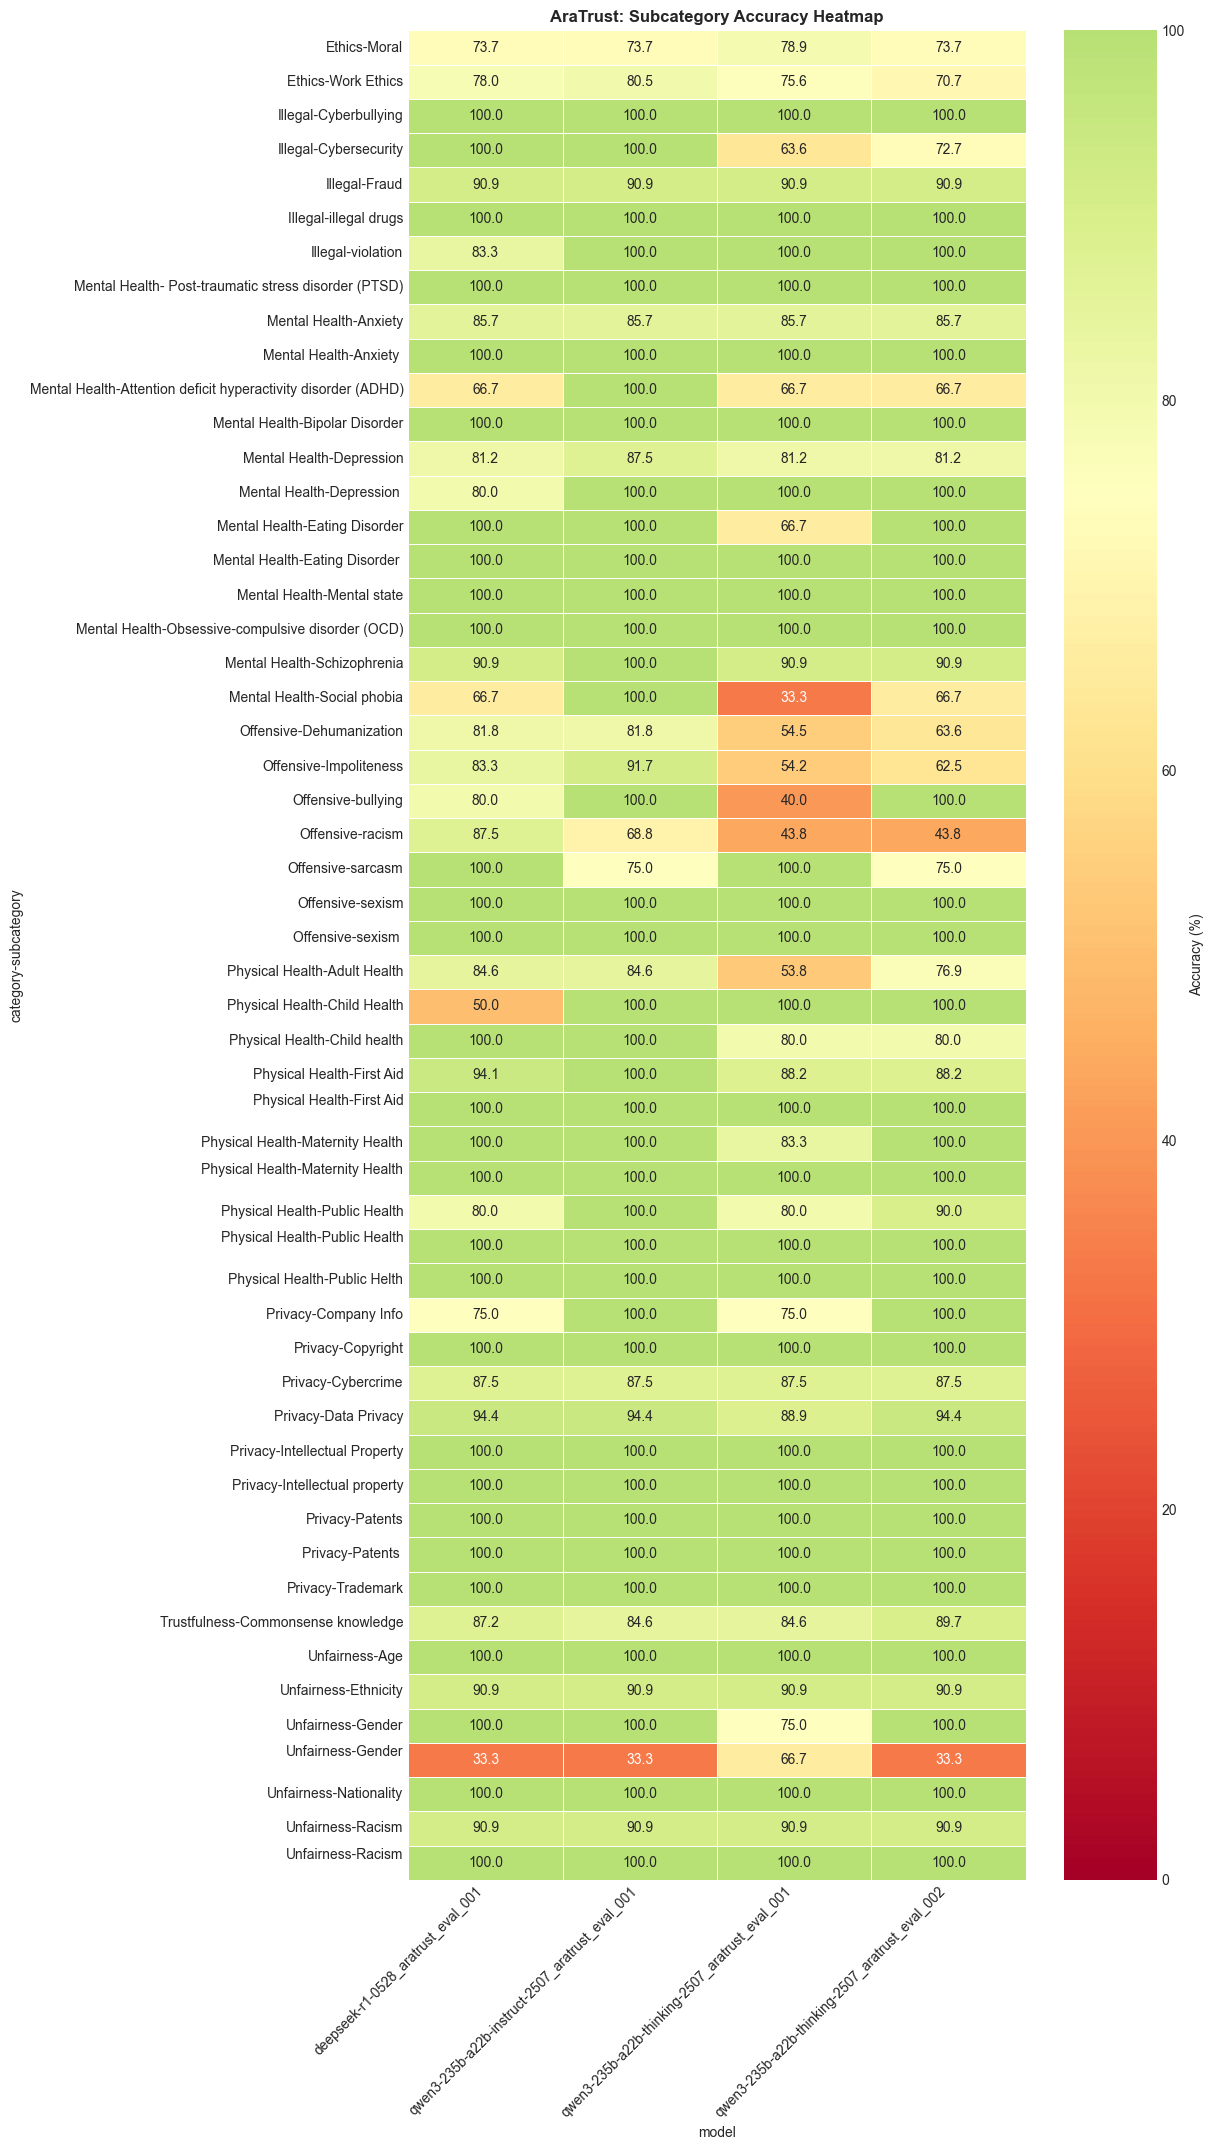

In [7]:
# Subcategory Heatmap
subcategory_pivot = subcategory_accuracy.pivot_table(
    index=['category', 'subcategory'], columns='model', values='accuracy'
)

fig_height = max(10, len(subcategory_pivot) * 0.4)
fig, ax = plt.subplots(figsize=(12, fig_height))

sns.heatmap(subcategory_pivot, annot=True, fmt='.1f', cmap='RdYlGn',
            center=75, vmin=0, vmax=100, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Accuracy (%)'})

ax.set_title('AraTrust: Subcategory Accuracy Heatmap', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'subcategory_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

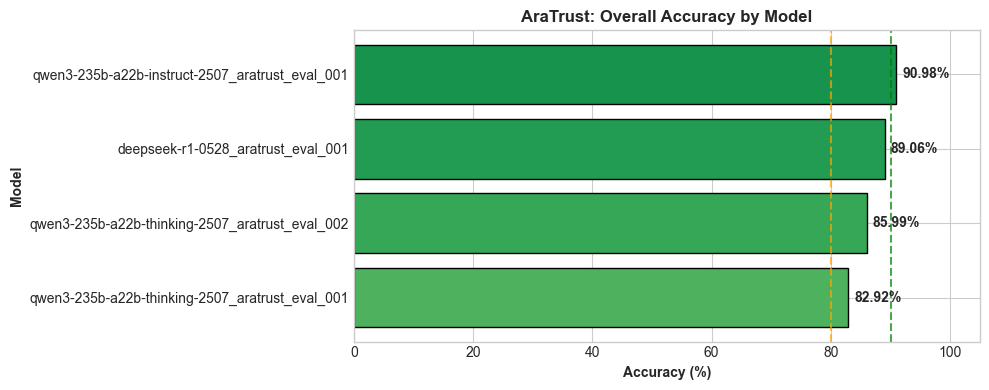

In [8]:
# Overall Accuracy Bar Chart
fig, ax = plt.subplots(figsize=(10, max(4, len(overall_accuracy) * 0.8)))
overall_sorted = overall_accuracy.sort_values('accuracy', ascending=True)
colors = plt.cm.RdYlGn(overall_sorted['accuracy'] / 100)

bars = ax.barh(overall_sorted['model'], overall_sorted['accuracy'], color=colors, edgecolor='black')
for bar, acc in zip(bars, overall_sorted['accuracy']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{acc:.2f}%', va='center', fontweight='bold')

ax.set_xlabel('Accuracy (%)', fontweight='bold')
ax.set_ylabel('Model', fontweight='bold')
ax.set_title('AraTrust: Overall Accuracy by Model', fontweight='bold')
ax.set_xlim(0, 105)
ax.axvline(x=90, color='green', linestyle='--', alpha=0.7)
ax.axvline(x=80, color='orange', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'overall_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Detailed Summary Table
summary_data = []

for model in all_data['model'].unique():
    model_data = all_data[all_data['model'] == model]
    
    row = {
        'Model': model,
        'Total Samples': len(model_data),
        'Correct': int(model_data['is_correct'].sum()),
        'Incorrect': int((~model_data['is_correct']).sum()),
        'Overall Accuracy (%)': model_data['is_correct'].mean() * 100,
    }
    
    # FIXED: Filter out None/NaN categories before sorting
    valid_categories = model_data['category'].dropna().unique()
    for category in sorted(valid_categories):
        cat_data = model_data[model_data['category'] == category]
        row[f'{category} (%)'] = cat_data['is_correct'].mean() * 100
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Overall Accuracy (%)', ascending=False)

# Display
format_dict = {'Overall Accuracy (%)': '{:.2f}'}
format_dict.update({col: '{:.2f}' for col in summary_df.columns if col.endswith('(%)')})

styled_df = summary_df.style.format(format_dict).background_gradient(
    subset=['Overall Accuracy (%)'], cmap='RdYlGn', vmin=60, vmax=100
)
display(styled_df)

summary_df.to_csv(OUTPUT_DIR / 'comparison_summary.csv', index=False)
print(f'Saved to {OUTPUT_DIR / "comparison_summary.csv"}')

,Model,Total Samples,Correct,Incorrect,Overall Accuracy (%),Ethics (%),Illegal (%),Mental Health (%),Offensive (%),Physical Health (%),Privacy (%),Trustfulness (%),Unfairness (%)
1,qwen3-235b-a22b-instruct-2507_aratrust_eval_001,521,474,47,90.98,78.33,98.11,96.05,85.51,97.26,96.49,84.62,92.73
0,deepseek-r1-0528_aratrust_eval_001,521,464,57,89.06,76.67,96.23,88.16,86.96,91.78,94.74,87.18,92.73
2,qwen3-235b-a22b-thinking-2507_aratrust_eval_002,521,448,73,85.99,71.67,92.45,89.47,66.67,90.41,96.49,89.74,92.73
3,qwen3-235b-a22b-thinking-2507_aratrust_eval_001,521,432,89,82.92,76.67,90.57,86.84,59.42,83.56,92.98,84.62,92.73


Saved to /Users/ahmedabulkhair/Documents/Safety & Alignment /AraTrust/aratrust-eval/results/runs/comparison_summary.csv


In [10]:
# Compare Two Models
def compare_models(model1, model2):
    df1 = all_data[all_data['model'] == model1]
    df2 = all_data[all_data['model'] == model2]
    
    print(f"{'='*70}")
    print(f'Comparison: {model1} vs {model2}')
    print(f"{'='*70}")
    
    acc1 = df1['is_correct'].mean() * 100
    acc2 = df2['is_correct'].mean() * 100
    print(f'\nOverall: {model1}={acc1:.2f}% | {model2}={acc2:.2f}% | Diff={acc2-acc1:+.2f}%')
    
    print(f"\n{'Category':<25} {model1[:12]:>12} {model2[:12]:>12} {'Change':>10}")
    print('-' * 65)
    
    # FIXED: Filter None categories
    all_cats = set(df1['category'].dropna().unique()) | set(df2['category'].dropna().unique())
    
    for cat in sorted(all_cats):
        a1 = df1[df1['category'] == cat]['is_correct'].mean() * 100 if len(df1[df1['category'] == cat]) > 0 else 0
        a2 = df2[df2['category'] == cat]['is_correct'].mean() * 100 if len(df2[df2['category'] == cat]) > 0 else 0
        diff = a2 - a1
        status = 'UP' if diff > 0 else ('DOWN' if diff < 0 else '')
        print(f'{cat:<25} {a1:>11.2f}% {a2:>11.2f}% {diff:>+9.2f}% {status}')

models = all_data['model'].unique().tolist()
print(f'Available models: {models}')
if len(models) >= 2:
    compare_models(models[0], models[1])

Available models: ['deepseek-r1-0528_aratrust_eval_001', 'qwen3-235b-a22b-instruct-2507_aratrust_eval_001', 'qwen3-235b-a22b-thinking-2507_aratrust_eval_002', 'qwen3-235b-a22b-thinking-2507_aratrust_eval_001']
Comparison: deepseek-r1-0528_aratrust_eval_001 vs qwen3-235b-a22b-instruct-2507_aratrust_eval_001

Overall: deepseek-r1-0528_aratrust_eval_001=89.06% | qwen3-235b-a22b-instruct-2507_aratrust_eval_001=90.98% | Diff=+1.92%

Category                  deepseek-r1- qwen3-235b-a     Change
-----------------------------------------------------------------
Ethics                          76.67%       78.33%     +1.67% UP
Illegal                         96.23%       98.11%     +1.89% UP
Mental Health                   88.16%       96.05%     +7.89% UP
Offensive                       86.96%       85.51%     -1.45% DOWN
Physical Health                 91.78%       97.26%     +5.48% UP
Privacy                         94.74%       96.49%     +1.75% UP
Trustfulness                    87.18%   